In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import tensorflow as tf 
import numpy as np 
import pickle
import numpy.random as rng
import matplotlib.pyplot as plt
from scipy.signal import lfilter

/opt/anaconda/miniconda2/envs/py34/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
fo=open('/home/prashanth/cifar-10-batches-py/data_batch_1','rb')
dict=pickle.load(fo,encoding='bytes')
X=dict[b'data']
Y=dict[b'labels']
fo.close
X=X.reshape((len(X),3,32,32)).transpose(0,2,3,1).astype("uint8")
Y=np.array(Y)


In [3]:
def forward_conv(height,width,inshape,outshape,input):
    weights=tf.Variable(rng.randn(height,width,inshape,outshape), dtype = tf.float32,name='conv_weights') #constant
    return(tf.nn.conv2d(input,weights,strides=[1,1,1,1],padding="SAME"))

def forward_pooling_layer(inp,window_size):
    return(tf.nn.max_pool(value=inp,ksize=[1,window_size,window_size,1],strides=[1,1,1,1],padding="SAME"))

def flatten_forward(layer):
    inp_list=layer.get_shape().as_list()
    new_size = inp_list[-1] * inp_list[-2] * inp_list[-3]
    return tf.reshape(layer,[-1,new_size]),new_size

def fc_forward(layer,new_size,no_of_classes):
    weights=tf.Variable(rng.randn(new_size,no_of_classes),dtype=tf.float32,name='fc_forward_weights') #constant
    return tf.matmul(layer,weights)

def fc_fc(rows,columns,layers):
    weights=tf.Variable(rng.randn(rows,columns),dtype=tf.float32,name='fc_fc_weights')
    return tf.matmul(layers,weights)

def activation(layer):
    return tf.nn.relu(layer)

In [4]:
@tf.RegisterGradient("CustomConv")
def _conv2d(op,grad):
    print("in override backprop")
    input = op.inputs[0]
    filter = op.inputs[1]
    in_shape = tf.shape(input)
    f_shape = tf.shape(filter)
    g_input = tf.nn.conv2d_backprop_input(input_sizes = in_shape, filter = filter, out_backprop = grad, strides = [1,1,1,1], padding = "SAME")
    g_filter = tf.nn.conv2d_backprop_filter(input, filter_sizes = f_shape, out_backprop = grad, strides = [1,1,1,1], padding = "SAME")
    return g_input, g_filter

In [5]:
#PARAMETERS
batch=100
iterations=10000
no_of_classes=10

# Random FeedBack

In [18]:
images=tf.placeholder(tf.float32,shape=(batch,32,32,3),name='images')
true_labels=tf.placeholder(tf.float32,shape=(batch,10),name='true_labels')

#net_conv=forward_conv(filter_conv,images)

#LAYER1
filter_random1 = tf.Variable(rng.randn(5,5,3,20), dtype = tf.float32,name='random_filter1')

g=tf.get_default_graph()
with g.gradient_override_map({"Conv2D": "CustomConv"}):
    net_conv=tf.nn.conv2d(images,filter_random1,strides=[1,1,1,1],padding="SAME")

net_pool= forward_pooling_layer(net_conv,2)
net_act=activation(net_pool)

#LAYER 2
filter_random2 = tf.Variable(rng.randn(5,5,20,50), dtype = tf.float32,name='random_filter2')
with g.gradient_override_map({"Conv2D":"CustomConv"}):
    net_conv2=tf.nn.conv2d(net_act,filter_random2,strides=[1,1,1,1],padding="SAME")
net_pool2= forward_pooling_layer(net_conv2,2)
net_act2=activation(net_pool2)
    
net_flatten,new_size=flatten_forward(net_act2)

net_fc=fc_forward(net_flatten,new_size,500)
net_act3=activation(net_fc)
output=fc_fc(500,no_of_classes,net_act3)

#compute loss

cross_entropy=tf.nn.softmax_cross_entropy_with_logits(logits=
                                  output,labels=true_labels)
cost = tf.reduce_mean(cross_entropy)


# Back Prop

In [19]:
# filter_conv_bp=tf.Variable(rng.randn(5,5,3,16), dtype = tf.float32)

#LAYER 1
net_conv_bp= forward_conv(5,5,3,20,images) # height,width,inshape,outshape
net_pool_bp = forward_pooling_layer(net_conv_bp,2) #output,windowsize
net_act_bp=activation(net_pool_bp)

#LAYER2
net_conv_bp2 = forward_conv(5,5,20,50,net_act_bp) # height,width,inshape,outshape
net_pool_bp2 = forward_pooling_layer(net_conv_bp2,2) #output,windowsize
net_act_bp2=activation(net_pool_bp2)

net_flatten_bp,new_size_bp=flatten_forward(net_act_bp2)
net_fc_bp1=fc_forward(net_flatten_bp,new_size_bp,500)
net_act_bp3=activation(net_fc_bp1)
output_bp=fc_fc(500,no_of_classes,net_act_bp3)


#cross_entropy_bp=tf.nn.softmax_cross_entropy_with_logits_v2(logits=
#                                  output_bp,labels=true_labels)
cross_entropy_bp=tf.nn.softmax_cross_entropy_with_logits(logits=
                                  output_bp,labels=true_labels)
cost_bp=tf.reduce_mean(cross_entropy_bp)

In [20]:
accuracy_fa=tf.reduce_mean(tf.cast(tf.equal(tf.argmax(output,1),tf.argmax(true_labels,1)),tf.float32))
accuracy_bp=tf.reduce_mean(tf.cast(tf.equal(tf.argmax(output_bp,1),tf.argmax(true_labels,1)),tf.float32))

In [21]:
#BP gradients
bp_grad = tf.gradients(cross_entropy_bp, images)

override_grad = tf.gradients(cross_entropy, images)

in override backprop
in override backprop


In [22]:
train_op_bp = tf.train.MomentumOptimizer(learning_rate=0.00000001,momentum=0.9).minimize(cost_bp)
train_op_fa=tf.train.MomentumOptimizer(learning_rate=0.00000001,momentum=0.9).minimize(cost)

in override backprop
in override backprop


In [23]:
Y_hot=np.eye(10)[Y]
store_err_bp=[]
store_err_fa=[]
acc_fa=[]
acc_bp=[]
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for count in range(iterations):
        batch_no=np.random.randint(0,X.shape[0],size=batch)
    
        inp_features=X[batch_no,:,:,:]
        inp_features=inp_features.astype(np.float32)
    
        inp_labels=Y_hot[batch_no,:]
        inp_labels=inp_labels.astype(np.float32)
    
        autobp_input=sess.run(bp_grad,feed_dict={images:inp_features,true_labels:inp_labels})
        override_input=sess.run(override_grad,feed_dict={images:inp_features,true_labels:inp_labels})
        
        sess.run(train_op_bp,feed_dict={images:inp_features,true_labels:inp_labels})
        sess.run(train_op_fa,feed_dict={images:inp_features,true_labels:inp_labels})
        
        entropy_bp=sess.run(cross_entropy_bp,feed_dict={images:inp_features,true_labels:inp_labels})
        store_err_bp.append(np.mean(entropy_bp))
        entropy_fa=sess.run(cross_entropy,feed_dict={images:inp_features,true_labels:inp_labels})
        store_err_fa.append(np.mean(entropy_fa))
        
        acc_fa.append(sess.run(accuracy_fa,feed_dict={images:inp_features,true_labels:inp_labels}))
        acc_bp.append(sess.run(accuracy_bp,feed_dict={images:inp_features,true_labels:inp_labels}))

        
        if count%100==0:
            print("Iteration:",count)
            print("BackPropagation:",sess.run(cost_bp,feed_dict={images:inp_features,true_labels:inp_labels}),"\nFeedback:",sess.run(cost,feed_dict={images:inp_features,true_labels:inp_labels}))

Iteration: 0
BackPropagation: 42784924.0 
Feedback: 48618988.0
Iteration: 100
BackPropagation: 967739.7 
Feedback: 207804.4
Iteration: 200
BackPropagation: 420626.97 
Feedback: 115527.75
Iteration: 300
BackPropagation: 292225.9 
Feedback: 48873.63
Iteration: 400
BackPropagation: 238216.8 
Feedback: 60056.73
Iteration: 500
BackPropagation: 177187.84 
Feedback: 34779.99
Iteration: 600
BackPropagation: 165180.98 
Feedback: 83301.42
Iteration: 700
BackPropagation: 121134.04 
Feedback: 17853.963
Iteration: 800
BackPropagation: 87323.24 
Feedback: 9114.613
Iteration: 900
BackPropagation: 74381.84 
Feedback: 21196.445
Iteration: 1000
BackPropagation: 82955.04 
Feedback: 24814.768
Iteration: 1100
BackPropagation: 61373.48 
Feedback: 37718.484
Iteration: 1200
BackPropagation: 32745.965 
Feedback: 19384.885
Iteration: 1300
BackPropagation: 44822.266 
Feedback: 23556.203
Iteration: 1400
BackPropagation: 38607.234 
Feedback: 12525.487
Iteration: 1500
BackPropagation: 21699.932 
Feedback: 5240.0293

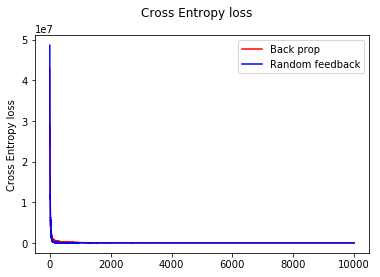

In [24]:
plt.plot(store_err_bp,'r',label='Back prop')
plt.plot(store_err_fa,'b',label='Random feedback')
plt.suptitle('Cross Entropy loss')
plt.ylabel('Cross Entropy loss')
plt.legend()
plt.show()

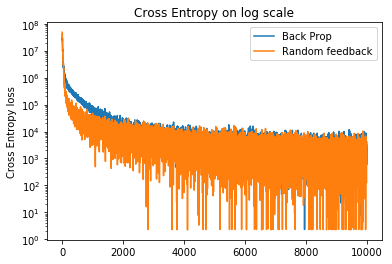

In [25]:
plt.semilogy(store_err_bp,label='Back Prop')
plt.semilogy(store_err_fa,label='Random feedback')
plt.title('Cross Entropy on log scale')
plt.ylabel('Cross Entropy loss')
plt.legend()
plt.show()

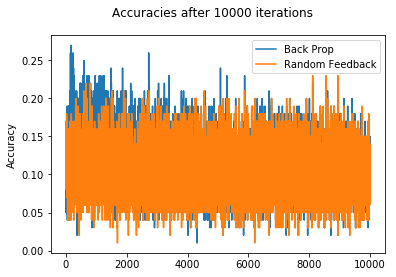

In [26]:
plt.plot(acc_bp,label='Back Prop')
plt.plot(acc_fa,label='Random Feedback')
plt.ylabel('Accuracy')
plt.suptitle("Accuracies after 10000 iterations")
plt.legend()
plt.show()

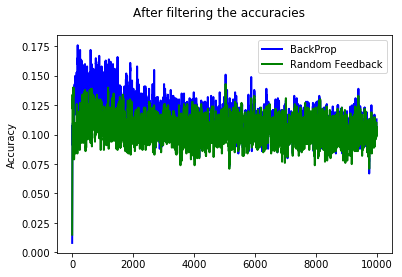

In [27]:
n = 10 # the larger n is, the smoother curve will be
b = [1.0 / n] * n
a = 1
yy_bp = lfilter(b,a,acc_bp)
yy_fa = lfilter(b,a,acc_fa)

plt.plot( yy_bp, linewidth=2, linestyle="-", c="b",label='BackProp')

plt.plot( yy_fa, linewidth=2, linestyle="-", c="g",label='Random Feedback')
plt.suptitle('After filtering the accuracies')
plt.legend()
plt.ylabel('Accuracy')
plt.show()